<a href="https://colab.research.google.com/github/SarkarPriyanshu/HumanActivityRecognition/blob/main/Human_activity_recognition_(Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

- Human activity recognition (HAR) is a critical task in fields like health monitoring, sports analysis, and mobile computing. Using mobile devices equipped with Inertial Measurement Unit (IMU) sensors, such as accelerometers and gyroscopes, it's possible to detect and classify human movements in real-time. In this project, we aim to leverage accelerometer and gyroscope data collected from mobile devices to accurately classify basic human activities, specifically distinguishing between "standing" and "walking."


**What is Inertial Measurement Unit**
- An Inertial Measurement Unit (IMU) is an electronic device that measures and reports a body’s specific force, angular rate, and sometimes the orientation of the body, using a combination of accelerometers, gyroscopes, and sometimes magnetometers.

Key Components:
- Accelerometers: Measure a changing acceleration on the sensor, allowing for the detection of tilt, force, or impact.
- Gyroscopes: Measure the angular rate (rotation) of the sensor, providing information on the body’s orientation and movement.

# Sensor Data Description

This dataset contains sensor readings from a mobile phone's accelerometer and gyroscope, along with a timestamp and an activity label.

### Columns:

1. **accX** (float):
   - Acceleration along the X-axis, in meters per second squared (m/s²). Measures how fast the device is accelerating in the left-right direction.

2. **accY** (float):
   - Acceleration along the Y-axis, in meters per second squared (m/s²). Measures how fast the device is accelerating in the up-down direction.

3. **accZ** (float):
   - Acceleration along the Z-axis, in meters per second squared (m/s²). Measures how fast the device is accelerating in the forward-backward direction.

4. **gyroX** (float):
   - Angular velocity around the X-axis, in radians per second (rad/s). Indicates how fast the phone is rotating around the X-axis (roll).

5. **gyroY** (float):
   - Angular velocity around the Y-axis, in radians per second (rad/s). Indicates how fast the phone is rotating around the Y-axis (pitch).

6. **gyroZ** (float):
   - Angular velocity around the Z-axis, in radians per second (rad/s). Indicates how fast the phone is rotating around the Z-axis (yaw).

7. **Timestamp** (time):
   - The time when the sensor reading was taken, in `HH:MM:SS` format.

8. **Activity** (integer):
   - A label for the activity being performed at the time of measurement:
     - `0` = Standing (or stationary, referred to as "stop")
     - `1` = Walking


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit

from scipy.stats import normaltest

from sklearn.preprocessing import StandardScaler,RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/DataSets/Data_health.csv')

# Basic Analysis

In [4]:
df.shape

(31991, 8)

In [5]:
df.head()

,accX,accY,accZ,gyroX,gyroY,gyroZ,timestamp,Activity
0,-0.496517,3.785628,8.954828,-0.142849,-0.126159,-0.022539,34:22.9,1
1,-0.462388,3.869603,9.281898,0.084349,0.096695,0.092130,34:23.0,1
2,-0.296084,3.820505,8.930728,0.061763,0.051543,0.071287,34:23.1,1
3,-0.469723,3.890110,8.744067,0.007641,0.028679,0.109433,34:23.2,1
4,-0.472418,4.109105,8.941207,-0.123640,0.099057,0.051943,34:23.3,1


In [6]:
df.isna().mean()/df.shape[0]

,0
accX,0.0
accY,0.0
accZ,0.0
gyroX,0.0
gyroY,0.0
gyroZ,0.0
timestamp,0.0
Activity,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31991 entries, 0 to 31990
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   accX       31991 non-null  float64
 1   accY       31991 non-null  float64
 2   accZ       31991 non-null  float64
 3   gyroX      31991 non-null  float64
 4   gyroY      31991 non-null  float64
 5   gyroZ      31991 non-null  float64
 6   timestamp  31991 non-null  object 
 7   Activity   31991 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 2.0+ MB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
accX,31991.0,0.023825,0.741396,-3.673361,-0.472193,-0.024998,0.477208,4.678671
accY,31991.0,2.153858,1.085466,-4.386029,1.413062,2.119143,2.928435,6.377039
accZ,31991.0,9.537909,2.056358,4.296066,7.794217,9.406739,11.158845,17.591568
gyroX,31991.0,-0.004493,0.307643,-1.470421,-0.149783,0.022301,0.177978,1.332722
gyroY,31991.0,-0.014756,0.249201,-1.430659,-0.162656,-0.011060,0.124966,1.480135
gyroZ,31991.0,-0.007021,0.266120,-1.894102,-0.154126,0.005261,0.152061,1.482268
Activity,31991.0,0.982151,0.132404,0.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df.duplicated().sum()

144

In [10]:
df.drop_duplicates(inplace=True)

# EDA

## Univariant Analysis

In [11]:
def NormalityTest(data):
 """
 Purpose:
    Determines whether a dataset follows a Gaussian (normal) distribution.
 Assumptions:
    Observations in each sample are independent and identically distributed (iid).
 Interpretation:
    H0: the sample has a Gaussian distribution.
    H1: the sample does not have a Gaussian distribution

 Input:
  data : Column (pd.Series)

 Output: p-value (float)



 """

 # Perform Shapiro-Wilk Test and print results
 stat1, p_value = normaltest(data)
 return p_value

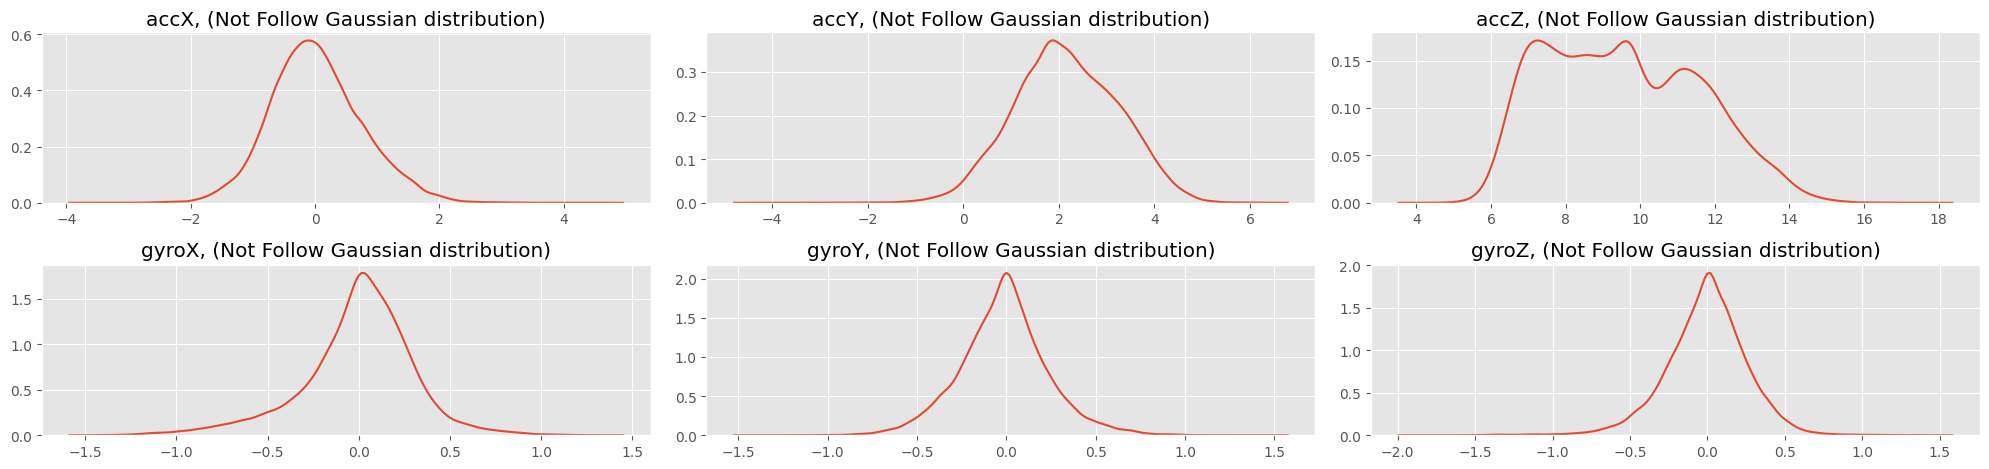

In [12]:
fig,axes = plt.subplots(2,3,figsize=(20,5))
features = df.columns.to_list()[:-2]
axes = axes.flatten()

for col,ax in zip(features,axes):
  p_value = NormalityTest(df[col])
  sns.kdeplot(data=df,x=col,ax=ax)
  ax.set_title(f'{col}, {"(Not Follow Gaussian distribution)" if p_value < 0.05 else "(Follows Gaussian distribution)"}')
  ax.set_xlabel('')
  ax.set_ylabel('')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

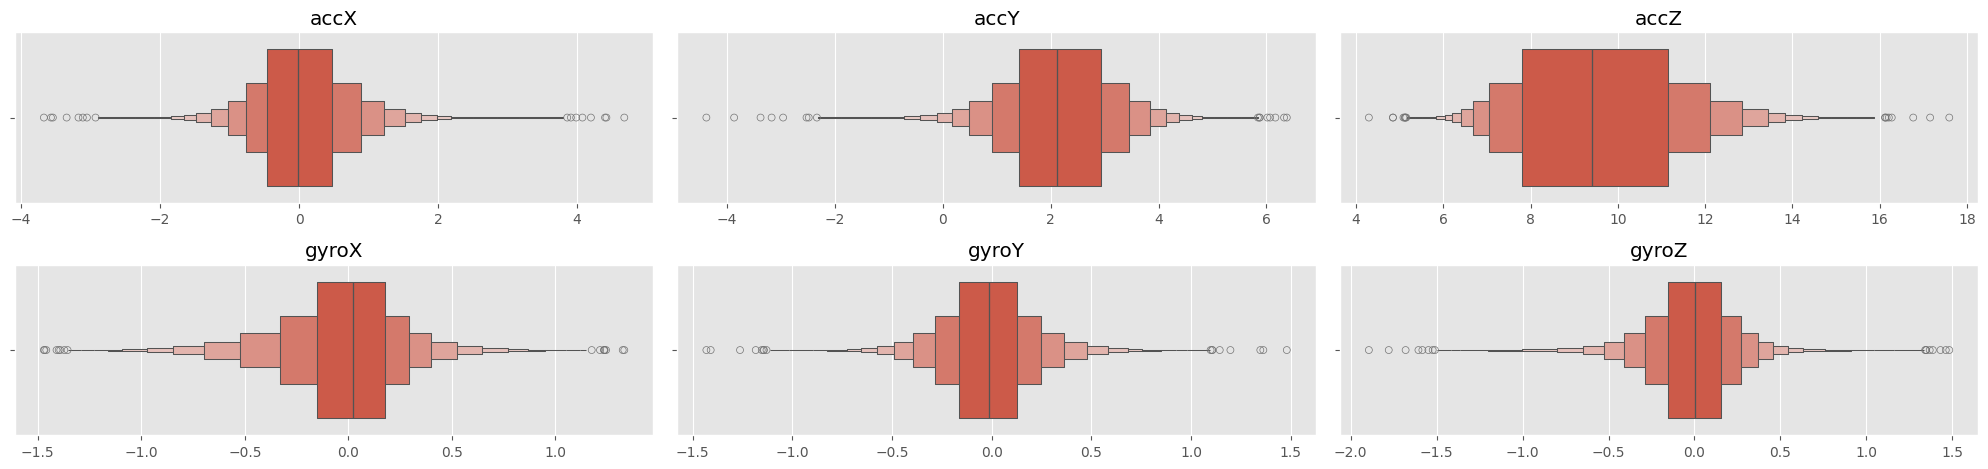

In [13]:
fig,axes = plt.subplots(2,3,figsize=(20,5))
features = df.columns.to_list()[:-2]
axes = axes.flatten()

for col,ax in zip(features,axes):
  sns.boxenplot(data=df,x=col,ax=ax)
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel('')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

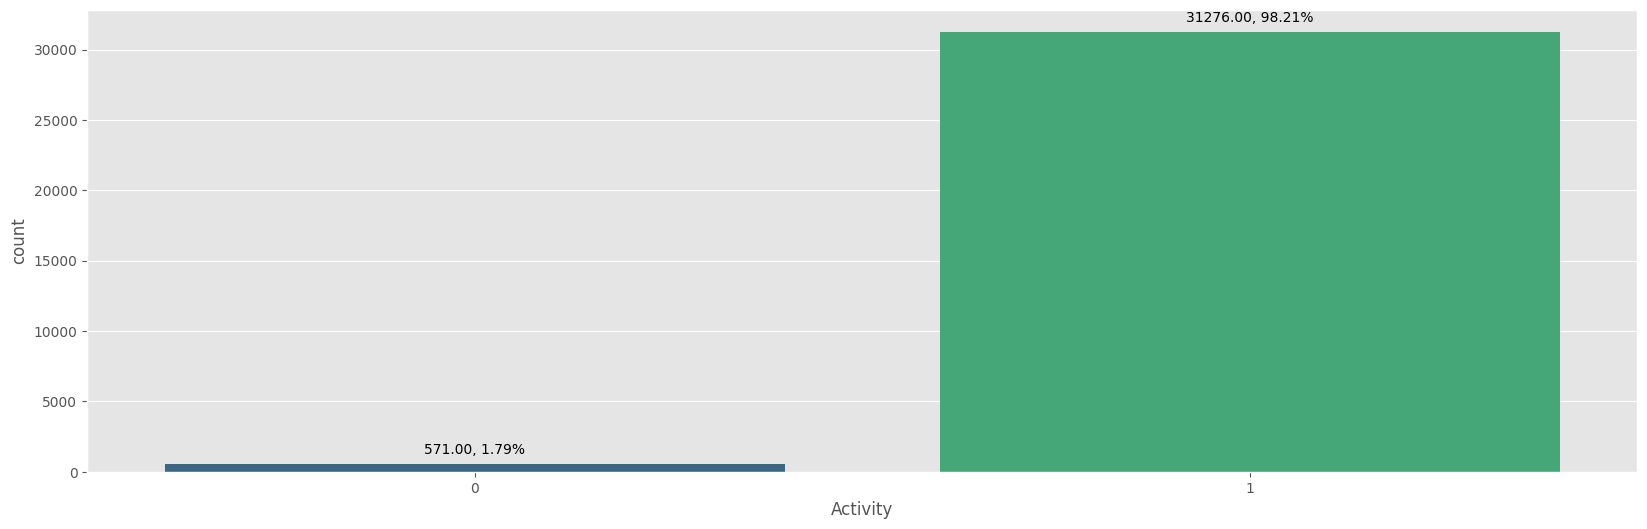

In [14]:
plt.figure(figsize=(20,6))
count = sns.countplot(data=df,x='Activity',palette='viridis',)
for p in count.patches:
  count.annotate(f'{format(p.get_height(), ".2f")}, {format(p.get_height()/df.shape[0] * 100,".2f")}%' , (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center',
                 xytext = (0, 10),
                 textcoords = 'offset points')
plt.show()

## Bivariant Analysis

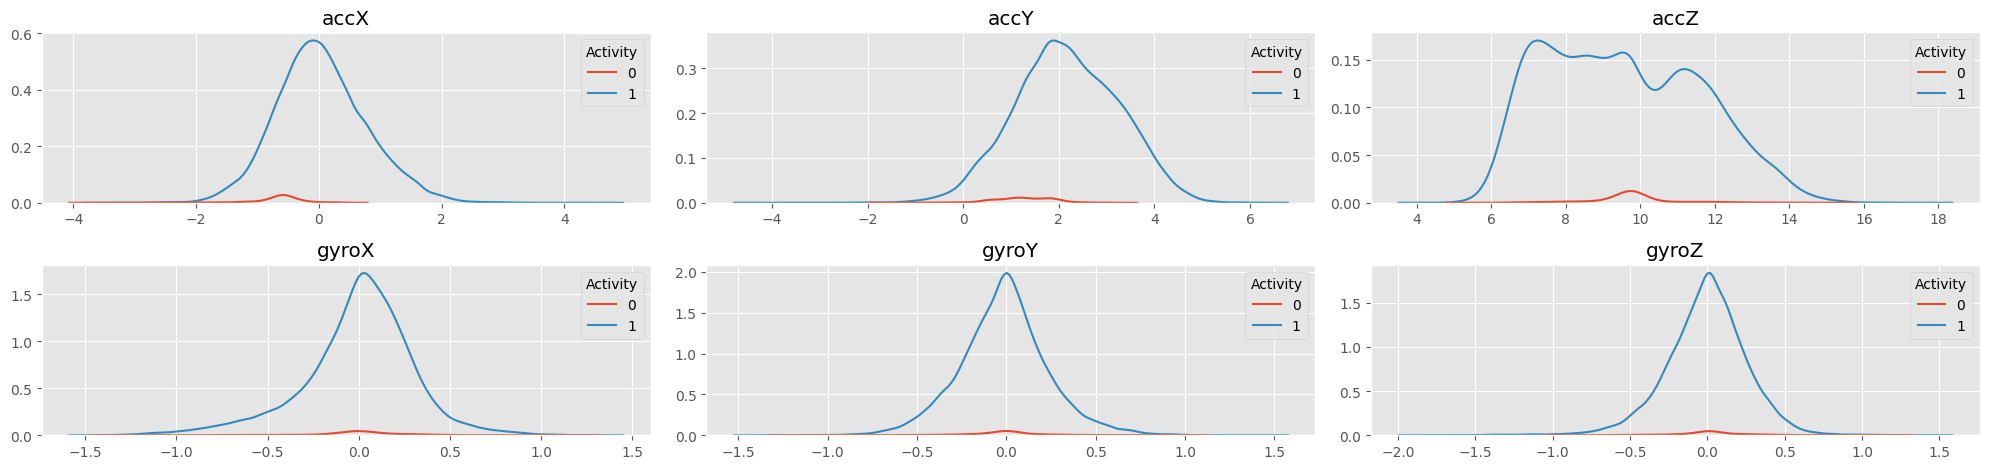

In [15]:
fig,axes = plt.subplots(2,3,figsize=(20,5))
features = df.columns.to_list()[:-2]
axes = axes.flatten()

for col,ax in zip(features,axes):
  sns.kdeplot(data=df,x=col,ax=ax,hue='Activity')
  ax.set_title(f'{col}')
  ax.set_xlabel('')
  ax.set_ylabel('')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

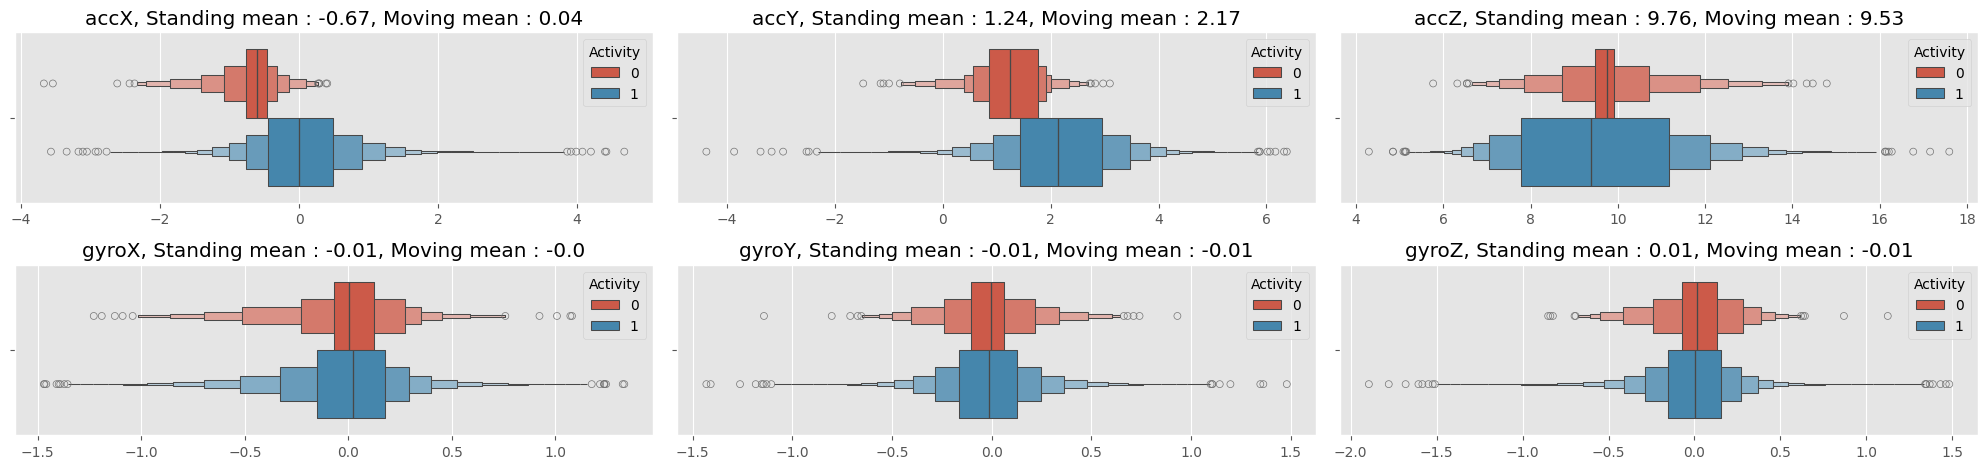

In [16]:
fig,axes = plt.subplots(2,3,figsize=(20,5))
features = df.columns.to_list()[:-2]
axes = axes.flatten()

for col,ax in zip(features,axes):
  standing_mean = round(df.query(f"Activity == 0")[col].mean(),2)
  moving_mean = round(df.query(f"Activity == 1")[col].mean(),2)
  sns.boxenplot(data=df,x=col,ax=ax,hue='Activity')
  ax.set_title(f'{col}, Standing mean : {standing_mean}, Moving mean : {moving_mean}')
  ax.set_xlabel('')
  ax.set_ylabel('')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

## Multivariant Analysis

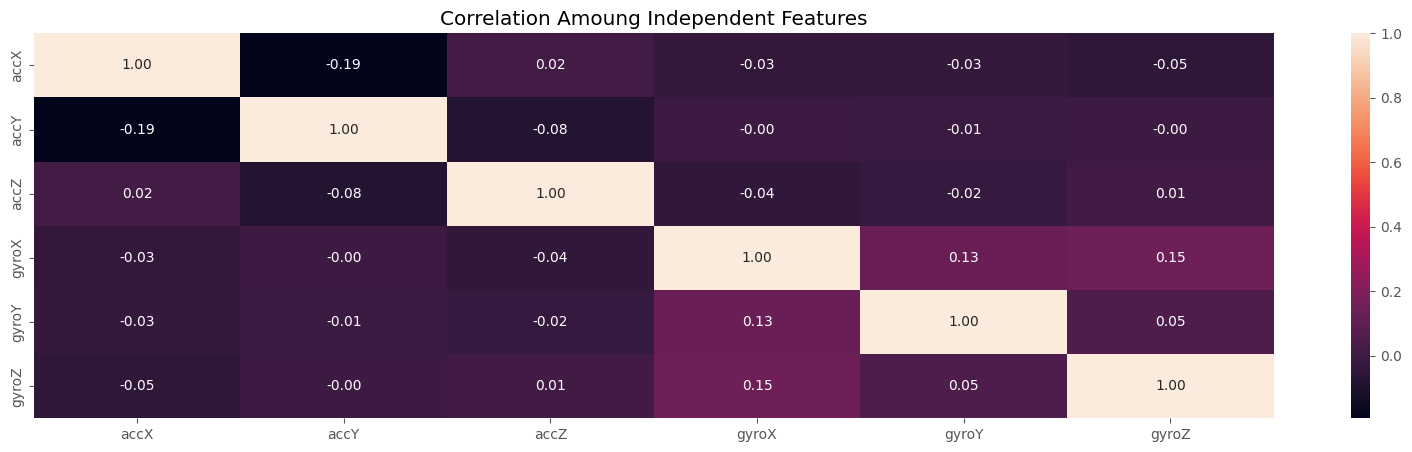

In [17]:
plt.figure(figsize=(20,5))
sns.heatmap(df[features].corr(),annot=True,fmt='.2f')
plt.title('Correlation Amoung Independent Features')
plt.show()

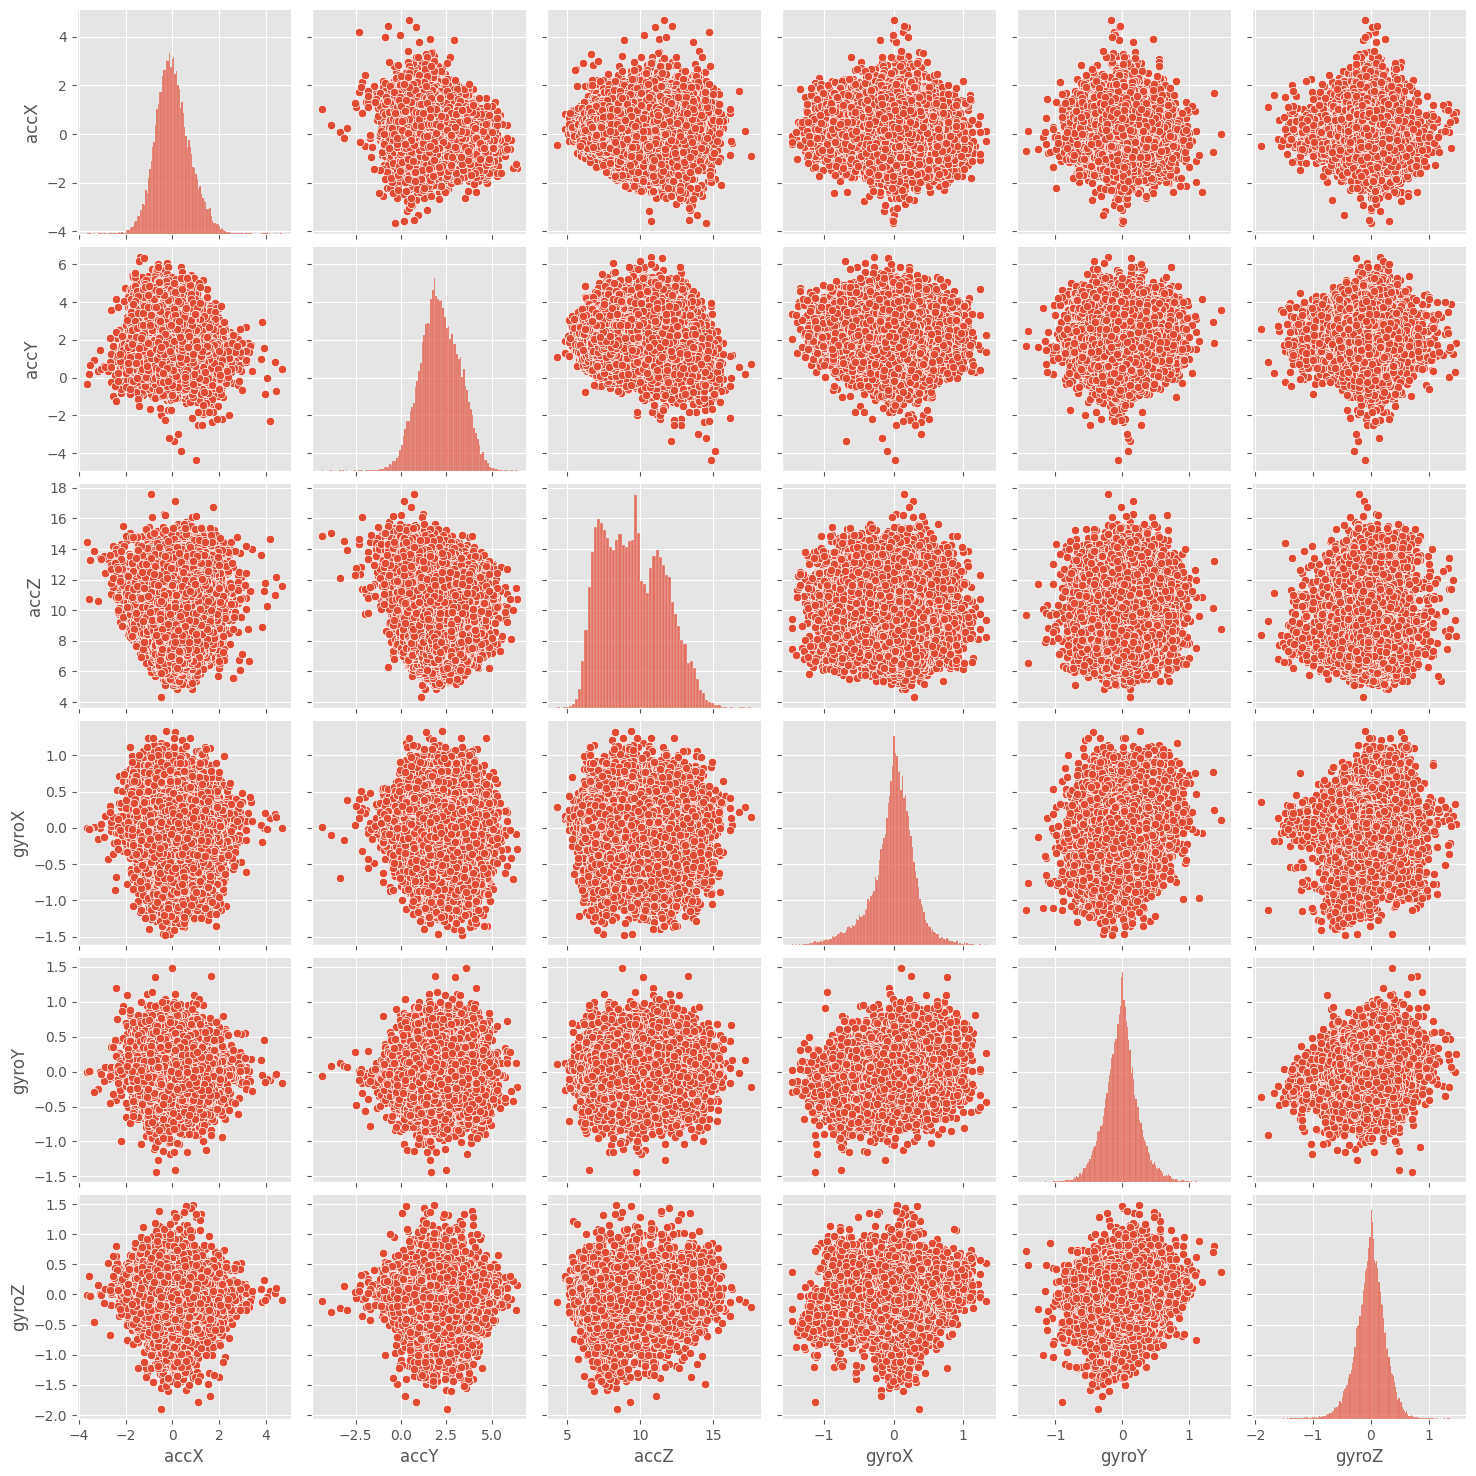

In [18]:
sns.pairplot(df[features])

In [19]:
# Splittig the data into (Train,Test,Val)

X,y = df.drop(['timestamp','Activity'],axis=1),df['Activity']

X_train, X_other, y_train, y_other = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_other)

print('Traning data: ',X_train.shape,'Testing data : ',X_test.shape,'Validation data : ',X_val.shape)

Traning data:  (25477, 6) Testing data :  (1274, 6) Validation data :  (5096, 6)


In [20]:
smt = SMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=3,
)

X_res, y_res = smt.fit_resample(X_train,y_train)

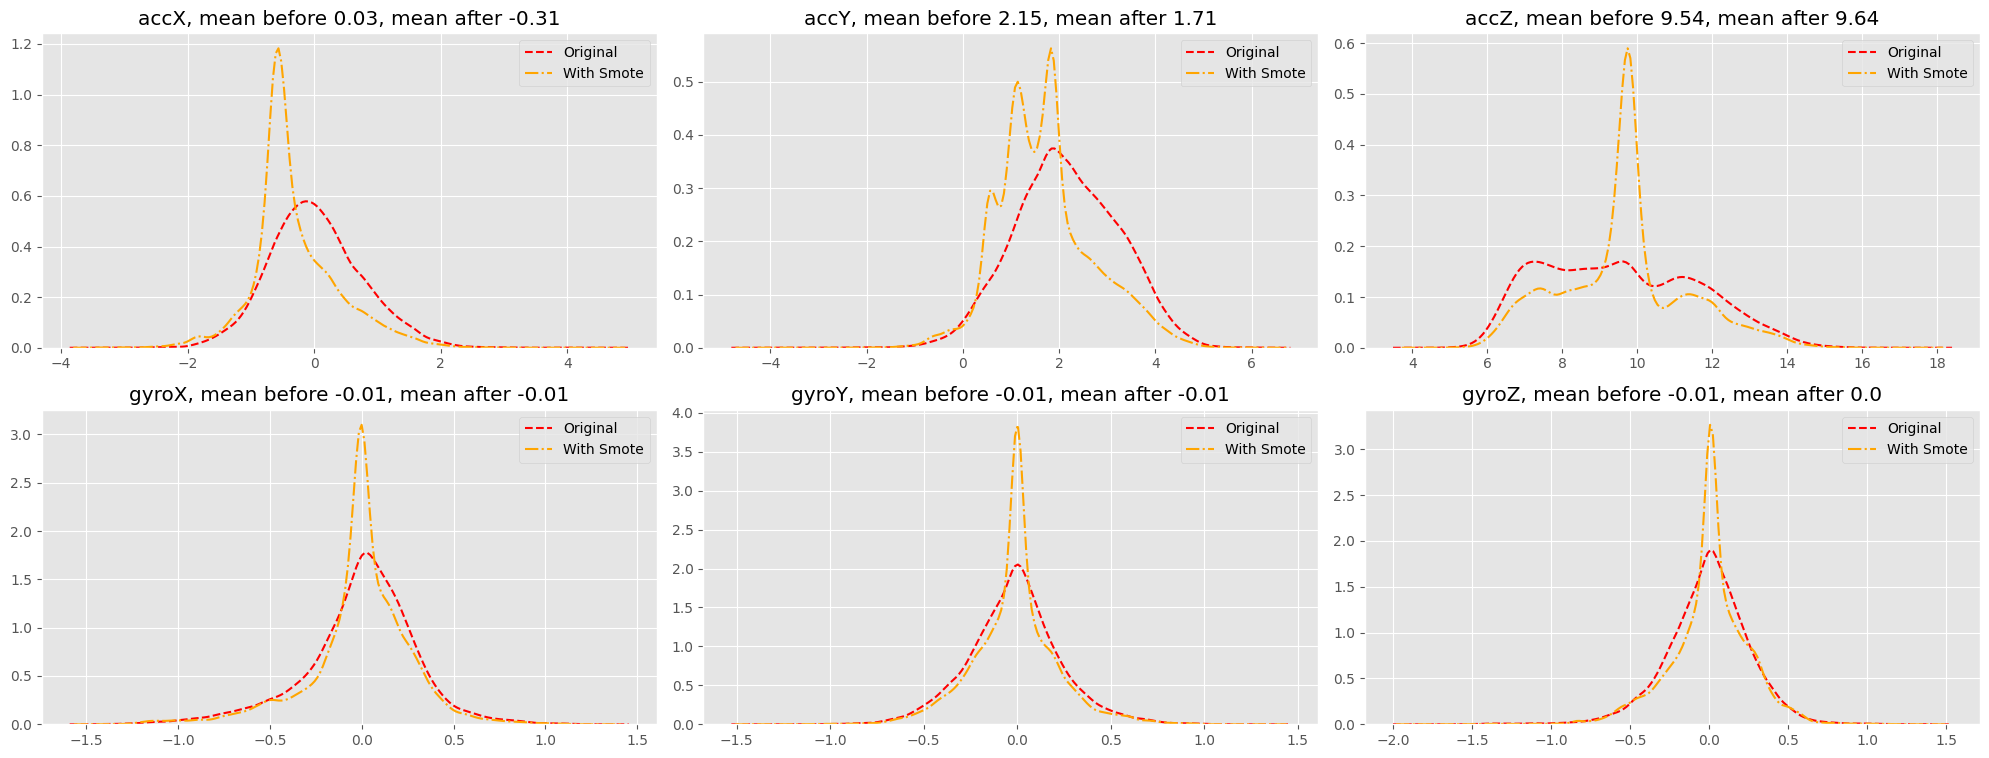

In [21]:
fig,axes = plt.subplots(2,3,figsize=(20,8))
features = X_train.columns.to_list()
axes = axes.flatten()

for col,ax in zip(features,axes):
  sns.kdeplot(data=X_train,x=col,ax=ax,ls='--',color='red',label='Original')
  sns.kdeplot(data=X_res,x=col,ax=ax,ls='-.',color='orange',label='With Smote')
  ax.set_title(f'{col}, mean before {round(X_train[col].mean(),2)}, mean after {round(X_res[col].mean(),2)}')
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.legend()

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


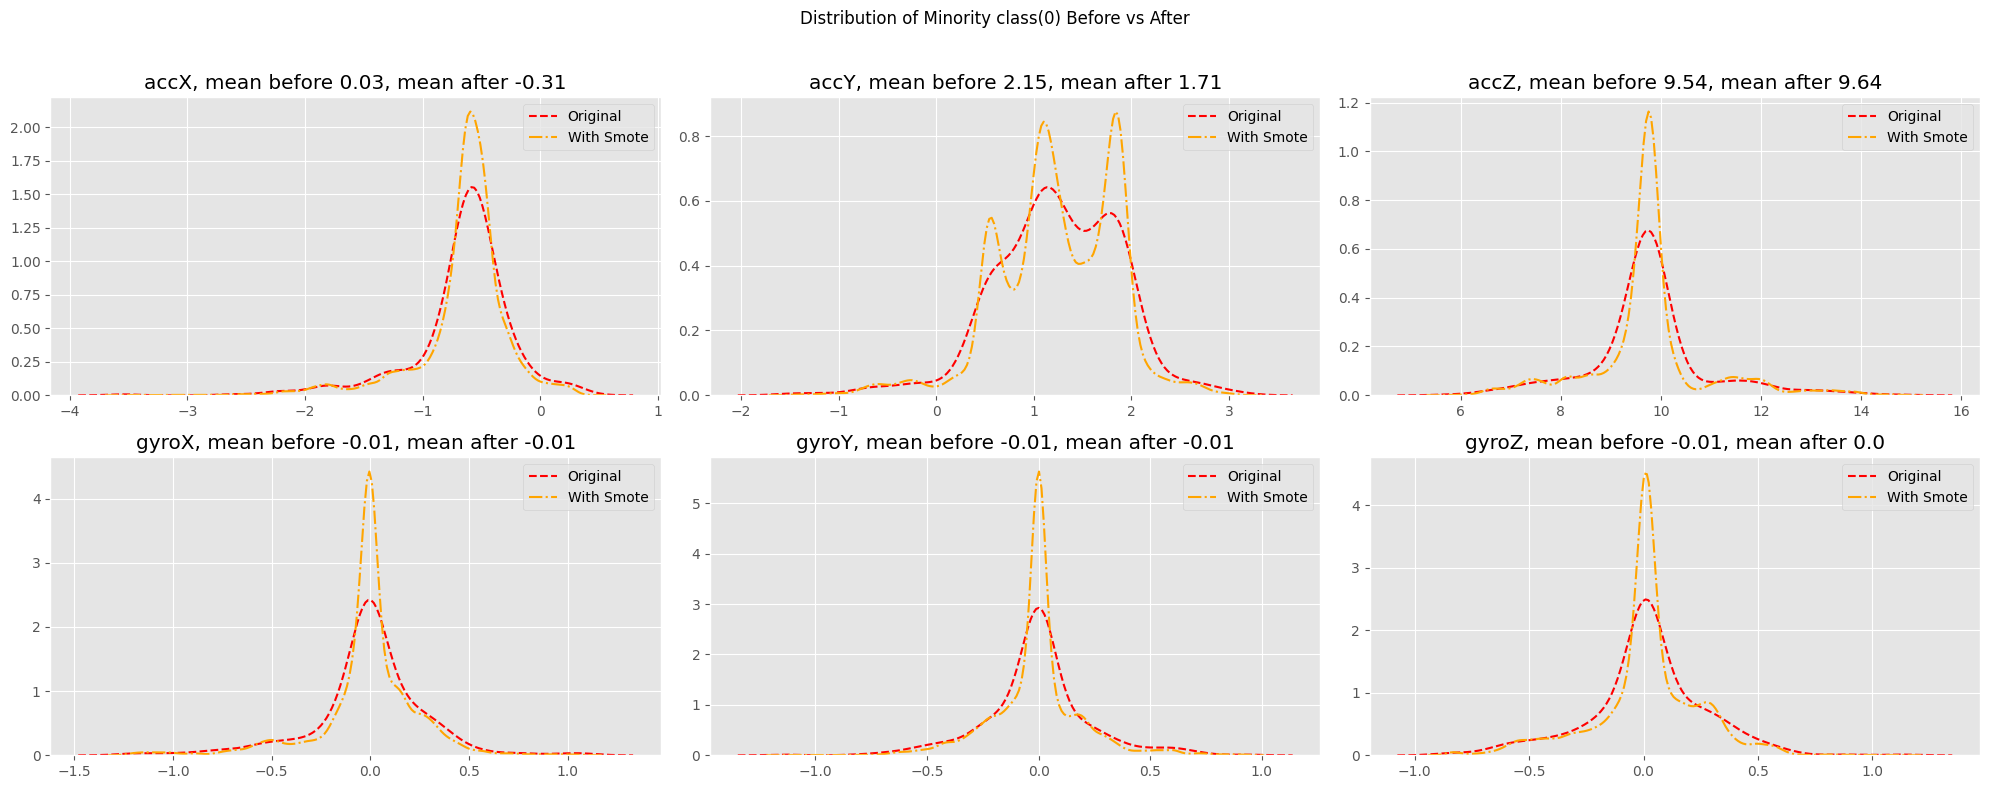

In [22]:
fig,axes = plt.subplots(2,3,figsize=(20,8))
features = X_train.columns.to_list()
axes = axes.flatten()

fig.suptitle('Distribution of Minority class(0) Before vs After')

original = pd.concat((X_train,y_train),axis=1).query('Activity == 0')
after_inpute = pd.concat((X_res, y_res),axis=1).query('Activity == 0')

for col,ax in zip(features,axes):
  sns.kdeplot(data=original,x=col,ax=ax,ls='--',color='red',label='Original')
  sns.kdeplot(data=after_inpute,x=col,ax=ax,ls='-.',color='orange',label='With Smote')
  ax.set_title(f'{col}, mean before {round(X_train[col].mean(),2)}, mean after {round(X_res[col].mean(),2)}')
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.legend()

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


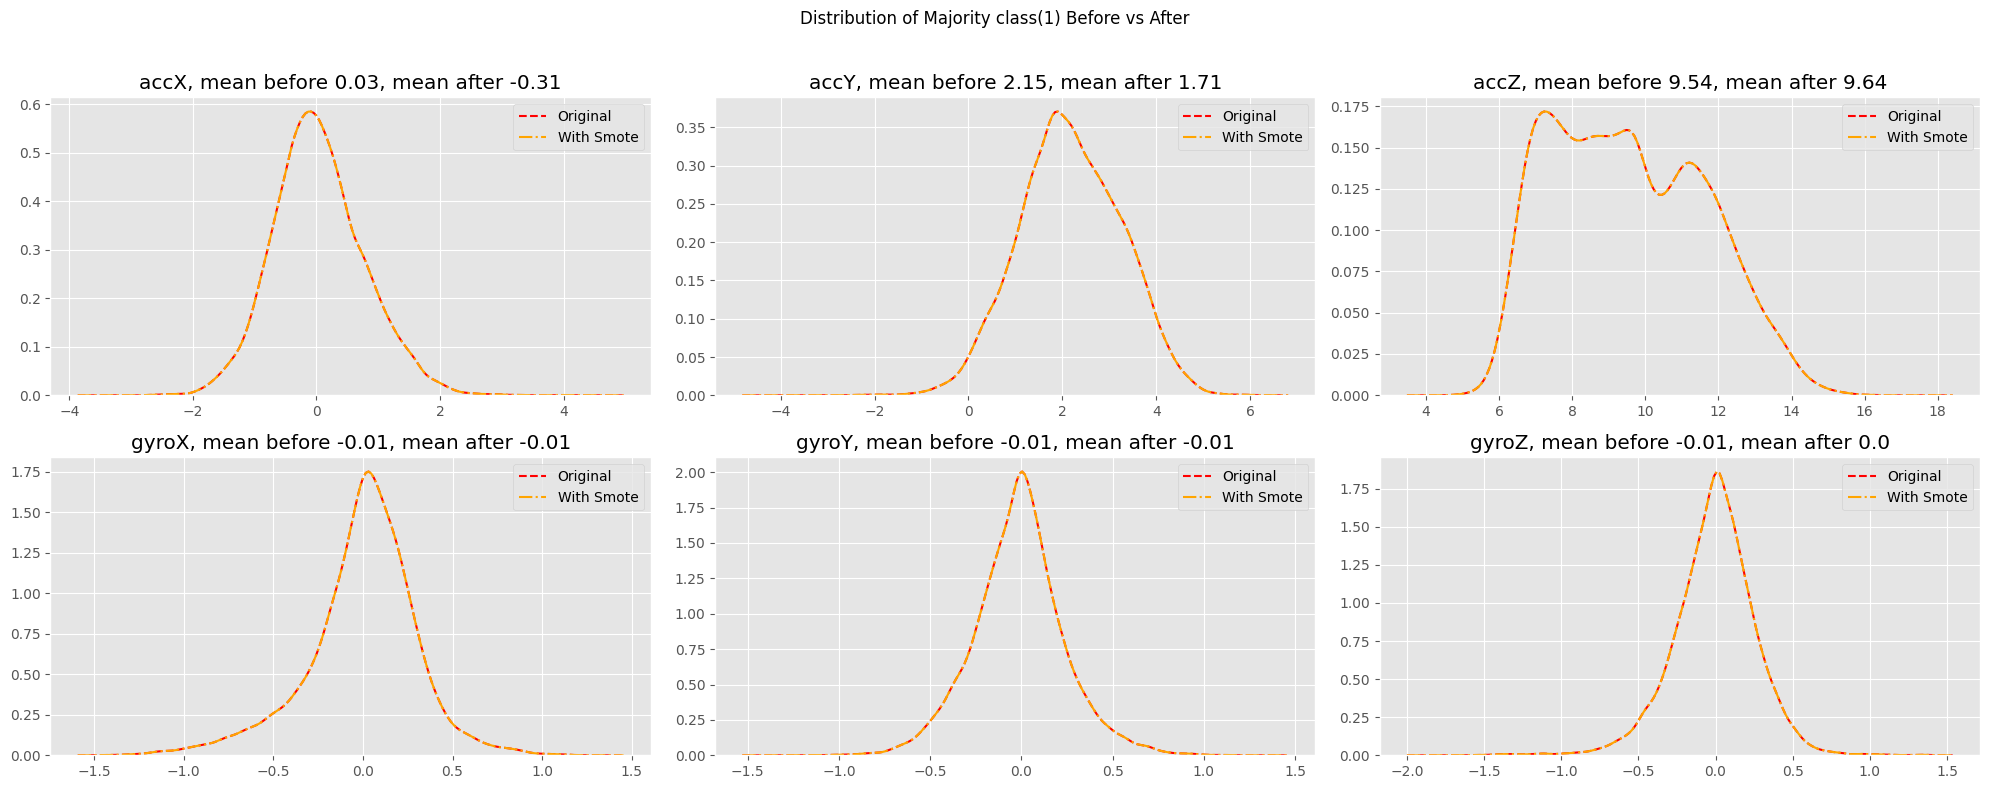

In [23]:
fig,axes = plt.subplots(2,3,figsize=(20,8))
features = X_train.columns.to_list()
axes = axes.flatten()

fig.suptitle('Distribution of Majority class(1) Before vs After')

original = pd.concat((X_train,y_train),axis=1).query('Activity == 1')
after_inpute = pd.concat((X_res, y_res),axis=1).query('Activity == 1')

for col,ax in zip(features,axes):
  sns.kdeplot(data=original,x=col,ax=ax,ls='--',color='red',label='Original')
  sns.kdeplot(data=after_inpute,x=col,ax=ax,ls='-.',color='orange',label='With Smote')
  ax.set_title(f'{col}, mean before {round(X_train[col].mean(),2)}, mean after {round(X_res[col].mean(),2)}')
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.legend()

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In [24]:
pd.concat((X_train,y_train),axis=1).query('Activity == 0').describe().T

,count,mean,std,min,25%,50%,75%,max
accX,457.0,-0.656806,0.434198,-3.544330,-0.748144,-0.600252,-0.460742,0.404160
accY,457.0,1.246112,0.631235,-1.477577,0.863105,1.234034,1.757795,3.096311
accZ,457.0,9.742602,1.173587,5.768554,9.450298,9.733808,9.917776,14.785204
gyroX,457.0,-0.006868,0.284596,-1.229589,-0.075405,-0.000545,0.125675,1.080128
gyroY,457.0,-0.007205,0.234007,-1.141854,-0.090515,-0.001650,0.060038,0.931542
gyroZ,457.0,0.014091,0.255703,-0.851049,-0.065517,0.012459,0.139830,1.124462
Activity,457.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
pd.concat((X_res, y_res),axis=1).query('Activity == 0').describe().T

,count,mean,std,min,25%,50%,75%,max
accX,25020.0,-0.652855,0.391531,-3.544330,-0.728285,-0.595486,-0.469384,0.404160
accY,25020.0,1.241221,0.603753,-1.477577,0.882151,1.224652,1.766358,3.096311
accZ,25020.0,9.747100,1.150302,5.768554,9.489373,9.745737,9.898126,14.785204
gyroX,25020.0,-0.011279,0.251787,-1.229589,-0.065295,-0.002288,0.087896,1.080128
gyroY,25020.0,-0.010156,0.198916,-1.141854,-0.077366,-0.002731,0.043028,0.931542
gyroZ,25020.0,0.013135,0.229037,-0.851049,-0.048772,0.013449,0.113196,1.124462
Activity,25020.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


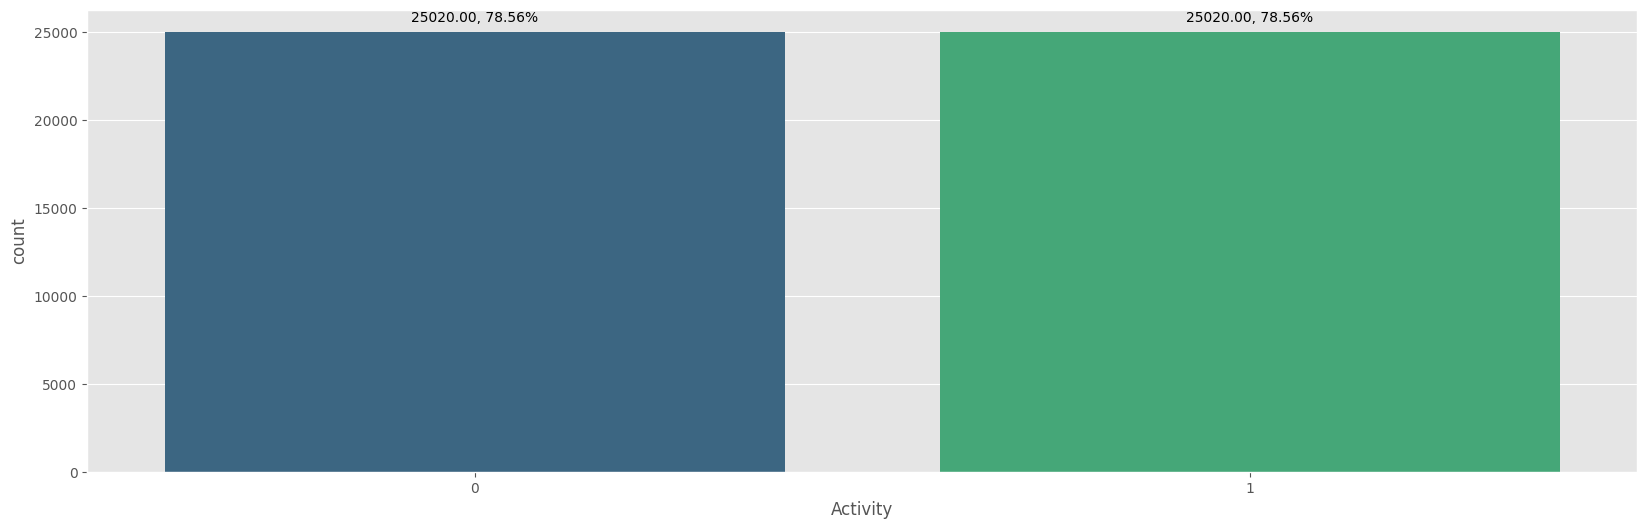

In [26]:
plt.figure(figsize=(20,6))
count = sns.countplot(data=pd.concat([X_res, y_res],axis=1),x='Activity',palette='viridis',)
for p in count.patches:
  count.annotate(f'{format(p.get_height(), ".2f")}, {format(p.get_height()/df.shape[0] * 100,".2f")}%' , (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center',
                 xytext = (0, 10),
                 textcoords = 'offset points')
plt.show()

In [27]:
scaler = StandardScaler()
scaler.fit(X_res, y_res)
X_res_tm = scaler.transform(X_res)
X_val_tm = scaler.transform(X_val)
X_test_tm = scaler.transform(X_test)

# Feature Significance

In [28]:
model = Logit(y_res,X_res_tm).fit(maxiter=50)

Optimization terminated successfully.
         Current function value: 0.413948
         Iterations 7


In [29]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:               Activity   No. Observations:                50040
Model:                          Logit   Df Residuals:                    50034
Method:                           MLE   Df Model:                            5
Date:                Tue, 19 Nov 2024   Pseudo R-squ.:                  0.4028
Time:                        09:52:29   Log-Likelihood:                -20714.
converged:                       True   LL-Null:                       -34685.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7833      0.019     93.956      0.000       1.746       1.820
x2             1.5159      0.017     87.972      0.000       1.482       1.550
x3             0.2366      0.014     17.307      0.0

In [30]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_res_tm, i) for i in range(X_res_tm.shape[1])]
vif['VIF'] = round(vif["VIF"], 2)
vif = vif.sort_values(by="VIF", ascending=False)

In [31]:
vif

,Features,VIF
1,accY,1.06
3,gyroX,1.05
2,accZ,1.04
4,gyroY,1.04
0,accX,1.03
5,gyroZ,1.02


In [32]:
model.conf_int().set_index(X_train.columns)

,0,1
accX,1.746071,1.820470
accY,1.482162,1.549711
accZ,0.209820,0.263411
gyroX,0.058172,0.106554
gyroY,-0.022976,0.025695
gyroZ,-0.097141,-0.048758


# Model Selection

In [33]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score,classification_report,confusion_matrix, ConfusionMatrixDisplay

**LogisticRegression**

In [34]:
start_time = time.time()
lr = LogisticRegression(max_iter=300,dual=True,solver='liblinear')
lr = lr.fit(X_res_tm,y_res)
print("--- Logistic Regression Traning in Seconds ---", (time.time() - start_time))

X_train_pred = lr.predict(X_res_tm)

start_time = time.time()
X_val_pred = lr.predict(X_val_tm)
print("--- Logistic Regression Prediction in Seconds ---", (time.time() - start_time))

--- Logistic Regression Traning in Seconds --- 0.6808230876922607
--- Logistic Regression Prediction in Seconds --- 0.0005578994750976562


In [35]:
print('train roc_auc_score :',roc_auc_score(y_res,X_train_pred))
print('val roc_auc_score :',roc_auc_score(y_val,X_val_pred))
print()


print('train classification report')
print()
print(classification_report(y_res,X_train_pred))
print()
print('val classification report')
print()
print(classification_report(y_val,X_val_pred))

train roc_auc_score : 0.856554756195044
val roc_auc_score : 0.8545454545454546

train classification report

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     25020
           1       0.91      0.79      0.85     25020

    accuracy                           0.86     50040
   macro avg       0.86      0.86      0.86     50040
weighted avg       0.86      0.86      0.86     50040


val classification report

              precision    recall  f1-score   support

           0       0.07      0.92      0.13        91
           1       1.00      0.79      0.88      5005

    accuracy                           0.79      5096
   macro avg       0.54      0.85      0.51      5096
weighted avg       0.98      0.79      0.87      5096



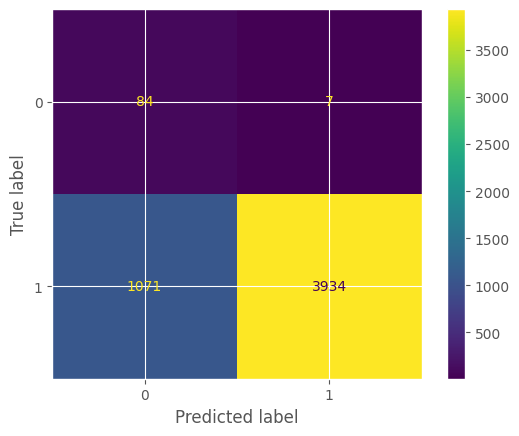

In [36]:
ConfusionMatrixDisplay.from_predictions(y_val,X_val_pred)

In [37]:
7/(84+7)*100,1059/(1059+3936)*100

(7.6923076923076925, 21.2012012012012)

**SGD Classifier**

In [38]:
start_time = time.time()
sgd = SGDClassifier()
sgd = sgd.fit(X_res_tm,y_res)
print("--- SGD Classifier Traning in Seconds ---",(time.time() - start_time))

X_train_pred = sgd.predict(X_res_tm)

start_time = time.time()
X_val_pred = sgd.predict(X_val_tm)
print("--- SGD Classifier Predction in Seconds ---",(time.time() - start_time))

--- SGD Classifier Traning in Seconds --- 0.08544015884399414
--- SGD Classifier Predction in Seconds --- 0.0005486011505126953


In [39]:
print('train roc_auc_score :',roc_auc_score(y_res,X_train_pred))
print('val roc_auc_score :',roc_auc_score(y_val,X_val_pred))
print()


print('train classification report')
print()
print(classification_report(y_res,X_train_pred))
print()
print('val classification report')
print()
print(classification_report(y_val,X_val_pred))

train roc_auc_score : 0.8455035971223022
val roc_auc_score : 0.8454545454545455

train classification report

              precision    recall  f1-score   support

           0       0.79      0.93      0.86     25020
           1       0.92      0.76      0.83     25020

    accuracy                           0.85     50040
   macro avg       0.86      0.85      0.84     50040
weighted avg       0.86      0.85      0.84     50040


val classification report

              precision    recall  f1-score   support

           0       0.07      0.93      0.12        91
           1       1.00      0.76      0.86      5005

    accuracy                           0.76      5096
   macro avg       0.53      0.85      0.49      5096
weighted avg       0.98      0.76      0.85      5096



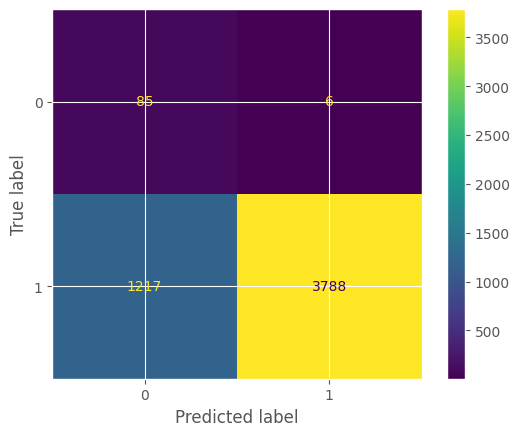

In [40]:
ConfusionMatrixDisplay.from_predictions(y_val,X_val_pred)

In [41]:
6/(85+6)*100,1279/(1279+3726)*100

(6.593406593406594, 25.554445554445554)

**Gaussian NB**

In [42]:
start_time = time.time()
gnb = GaussianNB()
gnb = gnb.fit(X_res_tm,y_res)
print("--- GaussianNB Traning in Seconds ---",(time.time() - start_time))

X_train_pred = gnb.predict(X_res_tm)

start_time = time.time()
X_val_pred = gnb.predict(X_val_tm)
print("--- GaussianNB Prediction in Seconds ---",(time.time() - start_time))

--- GaussianNB Traning in Seconds --- 0.011307477951049805
--- GaussianNB Prediction in Seconds --- 0.0008432865142822266


In [43]:
print('train roc_auc_score :',roc_auc_score(y_res,X_train_pred))
print('val roc_auc_score :',roc_auc_score(y_val,X_val_pred))
print()


print('train classification report')
print()
print(classification_report(y_res,X_train_pred))
print()
print('val classification report')
print()
print(classification_report(y_val,X_val_pred))

train roc_auc_score : 0.8559952038369304
val roc_auc_score : 0.8293706293706293

train classification report

              precision    recall  f1-score   support

           0       0.84      0.88      0.86     25020
           1       0.87      0.83      0.85     25020

    accuracy                           0.86     50040
   macro avg       0.86      0.86      0.86     50040
weighted avg       0.86      0.86      0.86     50040


val classification report

              precision    recall  f1-score   support

           0       0.08      0.82      0.15        91
           1       1.00      0.83      0.91      5005

    accuracy                           0.83      5096
   macro avg       0.54      0.83      0.53      5096
weighted avg       0.98      0.83      0.89      5096



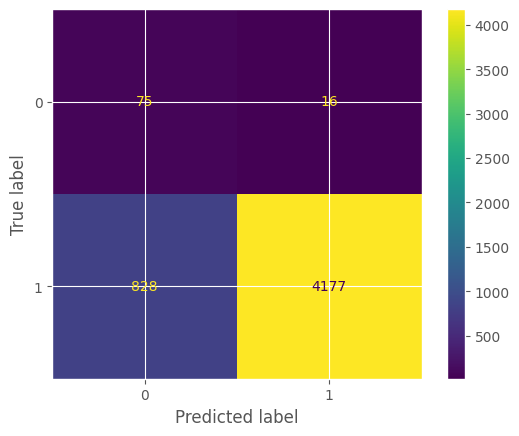

In [44]:
ConfusionMatrixDisplay.from_predictions(y_val,X_val_pred)

In [45]:
((13/(73+13)) * 100),819/(4186+816)*100

(15.11627906976744, 16.3734506197521)

**DecisionTree Classifier**

In [46]:
start_time = time.time()
dt = DecisionTreeClassifier(max_depth=5)
dt = dt.fit(X_res_tm,y_res)
print("--- DecisionTree Classifier Traning in Seconds ---",(time.time() - start_time))

X_train_pred = dt.predict(X_res_tm)

start_time = time.time()
X_val_pred = dt.predict(X_val_tm)
print("--- DecisionTree Classifier Predction in Seconds ---",(time.time() - start_time))

--- DecisionTree Classifier Traning in Seconds --- 0.2628288269042969
--- DecisionTree Classifier Predction in Seconds --- 0.0007042884826660156


In [47]:
print('train roc_auc_score :',roc_auc_score(y_res,X_train_pred))
print('val roc_auc_score :',roc_auc_score(y_val,X_val_pred))
print()


print('train classification report')
print()
print(classification_report(y_res,X_train_pred))
print()
print('val classification report')
print()
print(classification_report(y_val,X_val_pred))

train roc_auc_score : 0.8948840927258193
val roc_auc_score : 0.8643356643356643

train classification report

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     25020
           1       0.91      0.87      0.89     25020

    accuracy                           0.89     50040
   macro avg       0.90      0.89      0.89     50040
weighted avg       0.90      0.89      0.89     50040


val classification report

              precision    recall  f1-score   support

           0       0.11      0.86      0.19        91
           1       1.00      0.87      0.93      5005

    accuracy                           0.87      5096
   macro avg       0.55      0.86      0.56      5096
weighted avg       0.98      0.87      0.92      5096



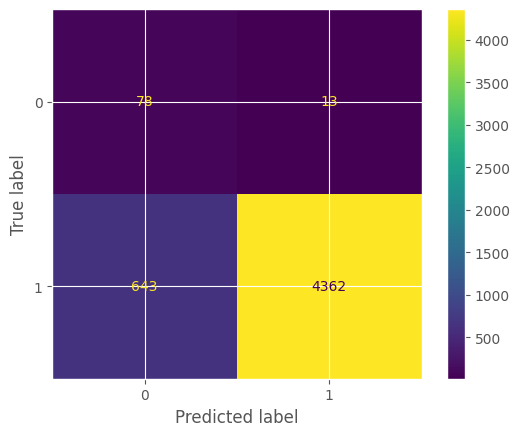

In [48]:
ConfusionMatrixDisplay.from_predictions(y_val,X_val_pred)

In [49]:
11/(80+11)*100,782/(782+4223)*100

(12.087912087912088, 15.624375624375626)

In [50]:
start_time = time.time()
rfc = RandomForestClassifier(max_depth=5)
rfc = rfc.fit(X_res_tm,y_res)
print("--- RandomForest Classifier Traning in Seconds ---",(time.time() - start_time))

X_train_pred = rfc.predict(X_res_tm)
start_time = time.time()
X_val_pred = rfc.predict(X_val_tm)
print("--- RandomForest Classifier Prediction in Seconds ---",(time.time() - start_time))

--- RandomForest Classifier Traning in Seconds --- 7.63774037361145
--- RandomForest Classifier Prediction in Seconds --- 0.03174233436584473


In [51]:
print('train roc_auc_score :',roc_auc_score(y_res,X_train_pred))
print('val roc_auc_score :',roc_auc_score(y_val,X_val_pred))
print()


print('train classification report')
print()
print(classification_report(y_res,X_train_pred))
print()
print('val classification report')
print()
print(classification_report(y_val,X_val_pred))

train roc_auc_score : 0.9018784972022382
val roc_auc_score : 0.8598401598401599

train classification report

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     25020
           1       0.93      0.87      0.90     25020

    accuracy                           0.90     50040
   macro avg       0.90      0.90      0.90     50040
weighted avg       0.90      0.90      0.90     50040


val classification report

              precision    recall  f1-score   support

           0       0.11      0.85      0.19        91
           1       1.00      0.87      0.93      5005

    accuracy                           0.87      5096
   macro avg       0.55      0.86      0.56      5096
weighted avg       0.98      0.87      0.92      5096



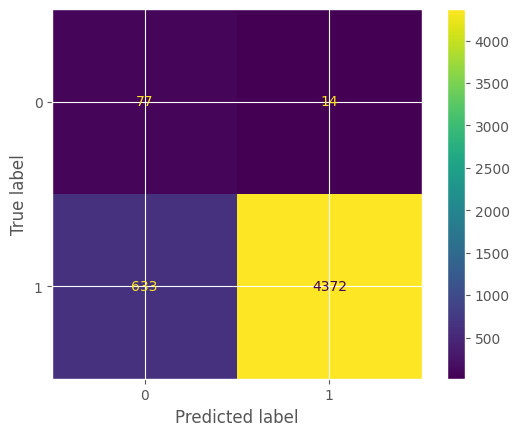

In [52]:
ConfusionMatrixDisplay.from_predictions(y_val,X_val_pred)

In [53]:
14/(77+14)*100,666/(666+4339)*100

(15.384615384615385, 13.306693306693306)

| Algorithm                  | Training Time Complexity          | Prediction Time Complexity        | Key Points                             |
|----------------------------|-----------------------------------|-----------------------------------|----------------------------------------|
| **SGDClassifier**           | \( O(n . m) \) per iteration  | \( O(m) \)                        | Efficient for large datasets, but depends on convergence |
| **Logistic Regression**     | \( O(n . m . k) \)        | \( O(m) \)                        | Uses batch gradient descent, slower for large datasets |
| **KNN**                     | \( O(1) \)                        | \( O(n . m) \) per prediction | No training phase, but expensive at prediction time |
| **SVM**                     | \( O(n^2 . m) \) to \( O(n^3) \) | \( O(n) \)                        | Expensive training time, fast prediction |
| **Decision Trees**          | \( O(n . m . \log n) \)   | \( O(\log n) \)                   | Efficient training, fast predictions    |
| **Random Forest**           | \( O(k . n . m . \log n) \) | \( O(k . \log n) \)           | Multiple trees, high training time     |
| **Naive Bayes**             | \( O(n . m) \)                | \( O(m) \)                        | Very fast training and prediction      |
| **Gradient Boosting**       | \( O(n . m . T) \)        | \( O(T . \log n) \)           | Slow training, but high accuracy       |


# Fine Tuning

In [54]:
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV

**SGD Classifier Pipeline**

In [55]:
preprocessor = make_column_transformer(
    (StandardScaler(),features),
    remainder='passthrough'
)

preprocessor.set_output(transform='pandas')
smote = SMOTE()
classifier = SGDClassifier()

pipeline = make_pipeline(preprocessor,smote,classifier)


param_grid = [
    {
        'smote__k_neighbors': [3, 5],
        'sgdclassifier__loss': ['hinge', 'log_loss', 'modified_huber','squared_hinge'],
        'sgdclassifier__learning_rate':['constant','optimal','invscaling','adaptive']
    }
]


# Setup GridSearchCV with cross-validation (cv=10) and parallel execution (n_jobs=-1)
grid_search = GridSearchCV(pipeline, param_grid, cv=10, verbose=1, n_jobs=-1)

# Fit the model to training data, making sure features_to_drop is defined correctly
grid_search.fit(X_train, y_train)

# View the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best parameters: {'sgdclassifier__learning_rate': 'optimal', 'sgdclassifier__loss': 'log_loss', 'smote__k_neighbors': 5}
Best score: 0.7980523304728251


In [56]:
sgd_model = grid_search.best_estimator_

In [57]:
X_train_pred = sgd_model.predict(X_train)
X_val_pred = sgd_model.predict(X_val)

print('train roc_auc_score :',roc_auc_score(y_train,X_train_pred))
print('val roc_auc_score :',roc_auc_score(y_val,X_val_pred))
print()


print('train classification report')
print()
print(classification_report(y_train,X_train_pred))
print()
print('val classification report')
print()
print(classification_report(y_val,X_val_pred))

train roc_auc_score : 0.8466091896723322
val roc_auc_score : 0.8557442557442557

train classification report

              precision    recall  f1-score   support

           0       0.07      0.90      0.14       457
           1       1.00      0.79      0.88     25020

    accuracy                           0.79     25477
   macro avg       0.54      0.85      0.51     25477
weighted avg       0.98      0.79      0.87     25477


val classification report

              precision    recall  f1-score   support

           0       0.07      0.92      0.14        91
           1       1.00      0.79      0.88      5005

    accuracy                           0.79      5096
   macro avg       0.54      0.86      0.51      5096
weighted avg       0.98      0.79      0.87      5096



In [58]:
start_time = time.time()
sgd = SGDClassifier(loss='log_loss',learning_rate='optimal')
sgd = sgd.fit(X_res_tm,y_res)
print("--- SGD Classifier Traning in Seconds ---",(time.time() - start_time))

X_train_pred = sgd.predict(X_res_tm)

start_time = time.time()
X_val_pred = sgd.predict(X_val_tm)
print("--- SGD Classifier Predction in Seconds ---",(time.time() - start_time))

--- SGD Classifier Traning in Seconds --- 0.08352446556091309
--- SGD Classifier Predction in Seconds --- 0.0006051063537597656


**Decision Tree Classifier Pipeline**

In [60]:
preprocessor = make_column_transformer(
    (StandardScaler(),features),
    remainder='passthrough'
)

preprocessor.set_output(transform='pandas')
smote = SMOTE()
classifier = DecisionTreeClassifier()

pipeline = make_pipeline(preprocessor,smote,classifier)


param_grid = [
    {
        'smote__k_neighbors': [3, 5],
        'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss'],
        'decisiontreeclassifier__max_depth':[5,6,7,8],
        'decisiontreeclassifier__min_samples_split':[0.1,0.2,0.3],
        'decisiontreeclassifier__max_features':['sqrt','log2']
    }
]


# Setup GridSearchCV with cross-validation (cv=10) and parallel execution (n_jobs=-1)
grid_search = GridSearchCV(pipeline, param_grid, cv=10, verbose=1, n_jobs=-1)

# Fit the model to training data, making sure features_to_drop is defined correctly
grid_search.fit(X_train, y_train)

# View the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best parameters: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 7, 'decisiontreeclassifier__max_features': 'log2', 'decisiontreeclassifier__min_samples_split': 0.1, 'smote__k_neighbors': 3}
Best score: 0.8623466429246338


In [61]:
dt_model = grid_search.best_estimator_

In [62]:
X_train_pred = dt_model.predict(X_train)
X_val_pred = dt_model.predict(X_val)

print('train roc_auc_score :',roc_auc_score(y_train,X_train_pred))
print('val roc_auc_score :',roc_auc_score(y_val,X_val_pred))
print()


print('train classification report')
print()
print(classification_report(y_train,X_train_pred))
print()
print('val classification report')
print()
print(classification_report(y_val,X_val_pred))

train roc_auc_score : 0.8446117066959123
val roc_auc_score : 0.8277722277722278

train classification report

              precision    recall  f1-score   support

           0       0.09      0.84      0.17       457
           1       1.00      0.85      0.92     25020

    accuracy                           0.85     25477
   macro avg       0.54      0.84      0.54     25477
weighted avg       0.98      0.85      0.90     25477


val classification report

              precision    recall  f1-score   support

           0       0.09      0.80      0.16        91
           1       1.00      0.85      0.92      5005

    accuracy                           0.85      5096
   macro avg       0.54      0.83      0.54      5096
weighted avg       0.98      0.85      0.91      5096



In [63]:
start_time = time.time()
dt = DecisionTreeClassifier(criterion='entropy',
                            max_depth=6,
                            max_features='sqrt',
                            min_samples_split=0.3
                            )

dt = dt.fit(X_res_tm,y_res)
print("--- DecisionTree Classifier Traning in Seconds ---",(time.time() - start_time))

X_train_pred = dt.predict(X_res_tm)

start_time = time.time()
X_val_pred = dt.predict(X_val_tm)
print("--- DecisionTree Classifier Predction in Seconds ---",(time.time() - start_time))

--- DecisionTree Classifier Traning in Seconds --- 0.09515023231506348
--- DecisionTree Classifier Predction in Seconds --- 0.0007700920104980469


**GaussianNB Classifier Pipeline**

In [71]:
preprocessor = make_column_transformer(
    (StandardScaler(),features),
    remainder='passthrough'
)

preprocessor.set_output(transform='pandas')
smote = SMOTE()
classifier = GaussianNB()

pipeline = make_pipeline(preprocessor,smote,classifier)


param_grid = [
    {
        'smote__k_neighbors': [3, 5],
        'gaussiannb__var_smoothing': [1e-09, 1e-07, 1e-05, 1e-03, 1e-02, 1e-01]
    }
]


# Setup GridSearchCV with cross-validation (cv=10) and parallel execution (n_jobs=-1)
grid_search = GridSearchCV(pipeline, param_grid, cv=10, verbose=1, n_jobs=-1)

# Fit the model to training data, making sure features_to_drop is defined correctly
grid_search.fit(X_train, y_train)

# View the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best parameters: {'gaussiannb__var_smoothing': 1e-07, 'smote__k_neighbors': 5}
Best score: 0.8409153133029962


In [72]:
gnb_model = grid_search.best_estimator_

In [73]:
X_train_pred = gnb_model.predict(X_train)
X_val_pred = gnb_model.predict(X_val)

print('train roc_auc_score :',roc_auc_score(y_train,X_train_pred))
print('val roc_auc_score :',roc_auc_score(y_val,X_val_pred))
print()


print('train classification report')
print()
print(classification_report(y_train,X_train_pred))
print()
print('val classification report')
print()
print(classification_report(y_val,X_val_pred))

train roc_auc_score : 0.8417239512547511
val roc_auc_score : 0.8195804195804196

train classification report

              precision    recall  f1-score   support

           0       0.09      0.84      0.16       457
           1       1.00      0.84      0.91     25020

    accuracy                           0.84     25477
   macro avg       0.54      0.84      0.53     25477
weighted avg       0.98      0.84      0.90     25477


val classification report

              precision    recall  f1-score   support

           0       0.08      0.80      0.15        91
           1       1.00      0.84      0.91      5005

    accuracy                           0.84      5096
   macro avg       0.54      0.82      0.53      5096
weighted avg       0.98      0.84      0.90      5096



In [74]:
start_time = time.time()
gnb = GaussianNB(var_smoothing= 1e-07)

gnb = gnb.fit(X_res_tm,y_res)
print("--- GaussianNB Classifier Traning in Seconds ---",(time.time() - start_time))

X_train_pred = gnb.predict(X_res_tm)

start_time = time.time()
X_val_pred = gnb.predict(X_val_tm)
print("--- GaussianNB Classifier Predction in Seconds ---",(time.time() - start_time))

--- GaussianNB Classifier Traning in Seconds --- 0.026557445526123047
--- GaussianNB Classifier Predction in Seconds --- 0.001439809799194336


# Performance on unseen data

**Decison Tree Performance on unseen data**

test roc_auc_score : 0.7145066555451292

test classification report

              precision    recall  f1-score   support

           0       0.09      0.52      0.16        23
           1       0.99      0.91      0.95      1251

    accuracy                           0.90      1274
   macro avg       0.54      0.71      0.55      1274
weighted avg       0.97      0.90      0.93      1274




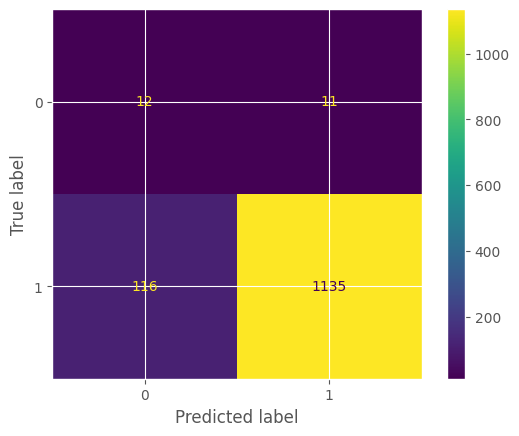

In [65]:
X_test_pred = dt.predict((X_test_tm))

print('test roc_auc_score :',roc_auc_score(y_test,X_test_pred))
print()
print('test classification report')
print()
print(classification_report(y_test,X_test_pred))
print()
ConfusionMatrixDisplay.from_predictions(y_test,X_test_pred)

**SGD Classifier Performance on unseen data**

test roc_auc_score : 0.8735446425468322

test classification report

              precision    recall  f1-score   support

           0       0.08      0.96      0.14        23
           1       1.00      0.79      0.88      1251

    accuracy                           0.79      1274
   macro avg       0.54      0.87      0.51      1274
weighted avg       0.98      0.79      0.87      1274




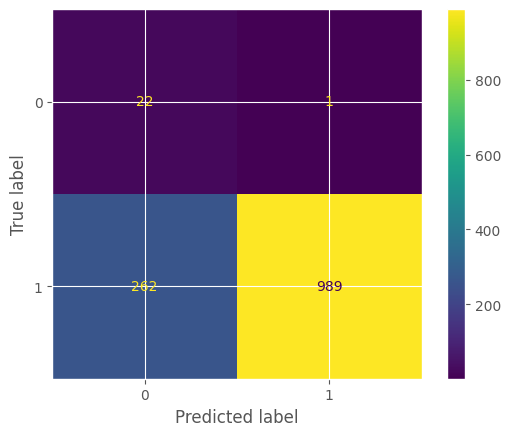

In [66]:
X_test_pred = sgd.predict(X_test_tm)

print('test roc_auc_score :',roc_auc_score(y_test,X_test_pred))
print()
print('test classification report')
print()
print(classification_report(y_test,X_test_pred))
print()
ConfusionMatrixDisplay.from_predictions(y_test,X_test_pred)

**GaussianNB Performance on unseen data**

test roc_auc_score : 0.8271122232648663

test classification report

              precision    recall  f1-score   support

           0       0.08      0.83      0.15        23
           1       1.00      0.83      0.90      1251

    accuracy                           0.83      1274
   macro avg       0.54      0.83      0.53      1274
weighted avg       0.98      0.83      0.89      1274




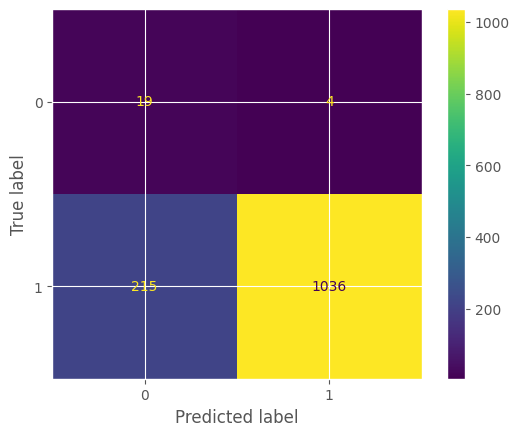

In [75]:
X_test_pred = gnb.predict(X_test_tm)

print('test roc_auc_score :',roc_auc_score(y_test,X_test_pred))
print()
print('test classification report')
print()
print(classification_report(y_test,X_test_pred))
print()
ConfusionMatrixDisplay.from_predictions(y_test,X_test_pred)